## Load dataset and train classifier

In [1]:
import time
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
%load_ext autoreload
%autoreload 2

In [2]:
from intabs.dataset import InnDataSet
data_name = "heloc"
dataset = InnDataSet(data_name)

Using TensorFlow backend.


[INFO] Using Python-MIP package version 1.12.0 [model.py <module>]
[WARNING] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.
 [lazy_loader.py _load]


In [3]:
from intabs.classifier_binary import cross_validation, train_clf, InnModel
d = dataset
num_h_neurons = 15
epochs = 10
cross_validation(d, num_h_neurons, epochs, data_name)

Using cuda device
accuracy: 0.7284189391090258+-0.01524783763489577


In [4]:
torch_model = train_clf(d.X1_train, d.y1_train, d.X1_test, d.y1_test, num_h_neurons, epochs, data_name, save_clf=False, load_clf=False)
model = InnModel(d, torch_model, num_h_neurons)

Evaluations on training data

                  precision    recall  f1-score   support

 bad credit (0)      0.757     0.696     0.725      2045
good credit (1)      0.699     0.760     0.728      1902

       accuracy                          0.727      3947
      macro avg      0.728     0.728     0.727      3947
   weighted avg      0.729     0.727     0.727      3947

Evaluations on testing data

                  precision    recall  f1-score   support

 bad credit (0)      0.774     0.691     0.730       511
good credit (1)      0.702     0.784     0.741       476

       accuracy                          0.736       987
      macro avg      0.738     0.737     0.735       987
   weighted avg      0.740     0.736     0.735       987



## Experiments 1

First, get $\delta$ value using incremental retraining, and get $\delta$ value using validation set

In [5]:
from intabs.evaluation import get_delta_incremental_training, get_retrained_models_and_validation_set, test_delta_with_val_set
percentages, delta_magnitudes = get_delta_incremental_training(d, model, batch_size=100)
inc_delta = delta_magnitudes[5].round(5) # select the delta value corresponding to retraining on 10% size of original data

100%|██████████| 51/51 [00:18<00:00,  2.78it/s]


In [6]:
print(inc_delta)

0.03982


In [7]:
model.raw_model.to("cpu")
rt_models, val_set, val_y_set = get_retrained_models_and_validation_set(d, model)

100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


In [8]:
val_delta = 0.02
print(test_delta_with_val_set(d, model, val_delta, val_set, rt_models))

0it [00:00, ?it/s]

Set parameter Username
[INFO] Set parameter Username [intabs.py __init__]
Academic license - for non-commercial use only - expires 2025-02-14
[INFO] Academic license - for non-commercial use only - expires 2025-02-14 [intabs.py __init__]


2599it [01:12, 35.65it/s]

True


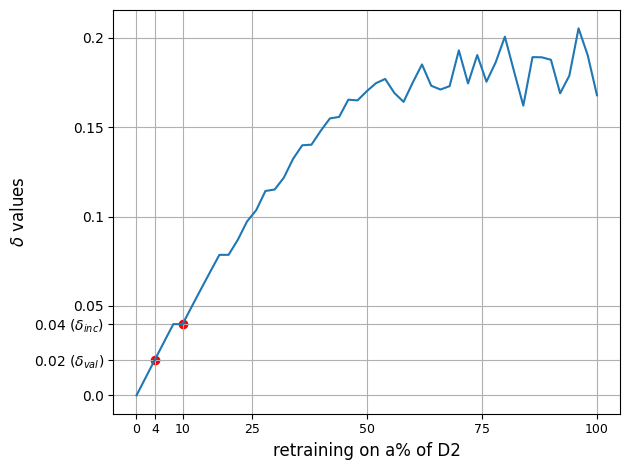

In [9]:
# plot
from intabs.evaluation import plot_deltas
plot_deltas(val_delta, inc_delta, percentages, delta_magnitudes, data_name)

## Experiments 2

Evaluating $\Delta$-robustness

In [10]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
from intabs.evaluation import *
test_set, test_set_df, test_set_full_df = get_test_inputs(d, model, 50)

In [11]:
from intabs.methods import roar, gce, mce, gce_r, mce_r, proto_r, rnce
deltas_plot = get_deltas_plot(inc_delta, val_delta)

In [12]:
roar_ces_plot = roar(test_set_full_df, model, lr=0.02, lambda_=0.001, delta_max=inc_delta)
roar_delta_validity = delta_robustness_test_for_plots(d, model, roar_ces_plot, deltas_plot)

In [13]:
gce_ces_plot = gce(test_set, model)
gce_delta_validity = delta_robustness_test_for_plots(d, model, gce_ces_plot, deltas_plot)

In [14]:
mce_ces_plot = mce(test_set, d, model)
mce_delta_validity = delta_robustness_test_for_plots(d, model, mce_ces_plot, deltas_plot)

In [15]:
proto_ces_plot = proto_r(test_set, d, model, plain=True)
proto_delta_validity = delta_robustness_test_for_plots(d, model, proto_ces_plot, deltas_plot)

0it [00:00, ?it/s]

[WARNING] From D:\Apps\anaconda\envs\proplace\lib\site-packages\alibi\explainers\cfproto.py:124: The name tf.keras.backend.get_session is deprecated. Please use tf.compat.v1.keras.backend.get_session instead.
 [module_wrapper.py _tfmw_add_deprecation_warning]


50it [23:54, 28.69s/it]


In [16]:
gcer_ces_plot = gce_r(test_set, d, model, delta=inc_delta)
gcer_delta_validity = delta_robustness_test_for_plots(d, model, gcer_ces_plot, deltas_plot)

50it [05:11,  6.23s/it]


In [17]:
mcer_ces_plot = mce_r(test_set, d, model, delta=inc_delta)
mcer_delta_validity = delta_robustness_test_for_plots(d, model, mcer_ces_plot, deltas_plot)

50it [00:54,  1.10s/it]


In [18]:
protor_ces_plot = proto_r(test_set, d, model, delta=inc_delta, plain=False, plain_proto_ces=proto_ces_plot)
protor_delta_validity = delta_robustness_test_for_plots(d, model, protor_ces_plot, deltas_plot)

50it [47:55, 57.50s/it]


In [19]:
rnce_ces_plot = rnce(test_set, d, model, delta=inc_delta)
rnce_delta_validity = delta_robustness_test_for_plots(d, model, rnce_ces_plot, deltas_plot)

5167it [02:18, 37.36it/s]


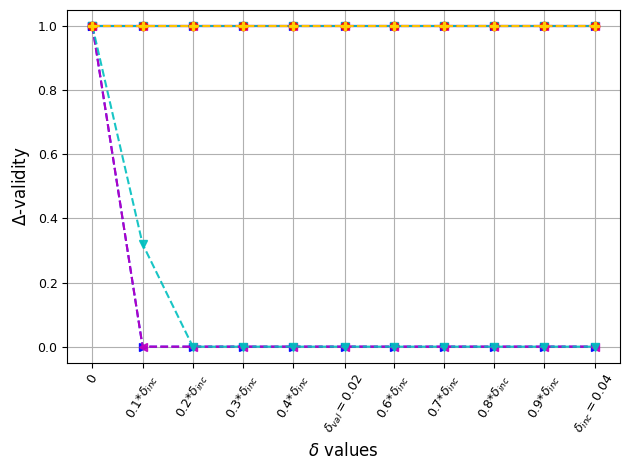

In [41]:
plot_delta_validity(deltas_plot, val_delta, gce_delta_validity, mce_delta_validity, proto_delta_validity, roar_delta_validity, gcer_delta_validity, mcer_delta_validity, protor_delta_validity, rnce_delta_validity, True, data_name)

In [39]:
# determine index
for i in range(len(deltas_plot)):
    print(deltas_plot[i] * 10 / inc_delta)

0.0
1.0
2.0
3.0
4.0
5.022601707684581
6.0
7.000000000000001
8.0
9.0
10.0


## Experiments 3

Benchmarking CEs

In [11]:
from intabs.evaluation import *
from intabs.methods import run_exps
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
rt_models_eval = get_retrained_models_all(d, model, num_h_neurons=num_h_neurons, epochs=epochs)

100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


In [12]:
from intabs.methods import run_exps_all_once
res_1 = run_exps_all_once(d, model, rt_models_eval, rt_models, inc_delta, val_delta, random_seed=1050,
                               run_id=1)


===== running experiments 1/5 =====
===== running non-robust baselines 1-4/17 =====


0it [00:00, ?it/s]

[WARNING] From D:\Apps\anaconda\envs\proplace\lib\site-packages\alibi\explainers\cfproto.py:124: The name tf.keras.backend.get_session is deprecated. Please use tf.compat.v1.keras.backend.get_session instead.
 [module_wrapper.py _tfmw_add_deprecation_warning]


20it [10:07, 30.40s/it]


===== running robust baselines 5-7/17 =====


20it [02:49,  8.50s/it]
20it [00:00, 203.01it/s]
20it [00:00, 106.22it/s]
20it [00:00, 39.99it/s]
20it [00:01, 11.87it/s]
20it [00:03,  5.38it/s]


===== running our methods 8-12/17, incremental delta =====


20it [02:07,  6.35s/it]
20it [00:15,  1.26it/s]
20it [19:26, 58.31s/it]
5167it [02:26, 35.35it/s]
20it [00:00, 27.64it/s]


===== running our methods 13-17/17, validation delta =====


20it [01:17,  3.86s/it]
20it [00:11,  1.68it/s]
20it [10:56, 32.83s/it]
5167it [02:22, 36.18it/s]
20it [00:00, 28.42it/s]


In [13]:
res_2 = run_exps_all_once(d, model, rt_models_eval, rt_models, inc_delta, val_delta, random_seed=7050,
                               run_id=2)

===== running experiments 2/5 =====
===== running non-robust baselines 1-4/17 =====


20it [10:08, 30.43s/it]


===== running robust baselines 5-7/17 =====


20it [02:59,  9.00s/it]
20it [00:00, 211.24it/s]
20it [00:00, 74.39it/s]
20it [00:00, 33.67it/s]
20it [00:02,  9.21it/s]
20it [00:03,  5.08it/s]


===== running our methods 8-12/17, incremental delta =====


20it [02:14,  6.74s/it]
20it [00:18,  1.10it/s]
20it [22:33, 67.69s/it]
5167it [02:29, 34.53it/s]
20it [00:00, 28.52it/s]


===== running our methods 13-17/17, validation delta =====


20it [01:16,  3.83s/it]
20it [00:13,  1.53it/s]
20it [12:58, 38.93s/it]
5167it [02:27, 35.15it/s]
20it [00:00, 27.59it/s]


In [14]:
res_3 = run_exps_all_once(d, model, rt_models_eval, rt_models, inc_delta, val_delta, random_seed=3050,
                               run_id=3)

===== running experiments 3/5 =====
===== running non-robust baselines 1-4/17 =====


20it [12:12, 36.65s/it]


===== running robust baselines 5-7/17 =====


20it [02:40,  8.04s/it]
20it [00:00, 202.85it/s]
20it [00:00, 74.31it/s]
20it [00:00, 26.05it/s]
20it [00:01, 10.37it/s]


===== running our methods 8-12/17, incremental delta =====


20it [01:44,  5.20s/it]
20it [00:17,  1.14it/s]
20it [20:28, 61.40s/it]
5167it [02:40, 32.19it/s]
20it [00:00, 22.89it/s]


===== running our methods 13-17/17, validation delta =====


20it [01:58,  5.94s/it]
20it [00:13,  1.49it/s]
20it [17:46, 53.33s/it]
5167it [04:11, 20.58it/s]
20it [00:00, 24.13it/s]


In [15]:
res_4 = run_exps_all_once(d, model, rt_models_eval, rt_models, inc_delta, val_delta, random_seed=3990,
                               run_id=4)

===== running experiments 4/5 =====
===== running non-robust baselines 1-4/17 =====


20it [14:43, 44.20s/it]


===== running robust baselines 5-7/17 =====


20it [03:00,  9.05s/it]
20it [00:00, 126.17it/s]
20it [00:00, 53.83it/s]
20it [00:01, 19.31it/s]
20it [00:02,  8.06it/s]
20it [00:03,  5.64it/s]


===== running our methods 8-12/17, incremental delta =====


20it [02:19,  6.95s/it]
20it [00:21,  1.07s/it]
20it [23:18, 69.92s/it]
5167it [02:46, 31.01it/s]
20it [00:00, 25.79it/s]


===== running our methods 13-17/17, validation delta =====


20it [01:16,  3.81s/it]
20it [00:16,  1.22it/s]
20it [11:41, 35.07s/it]
5167it [02:47, 30.76it/s]
20it [00:00, 24.67it/s]


In [16]:
res_5 = run_exps_all_once(d, model, rt_models_eval, rt_models, inc_delta, val_delta, random_seed=6666,
                               run_id=5)

===== running experiments 5/5 =====
===== running non-robust baselines 1-4/17 =====


20it [11:25, 34.25s/it]


===== running robust baselines 5-7/17 =====


20it [02:36,  7.83s/it]
20it [00:00, 134.08it/s]
20it [00:00, 52.48it/s]
20it [00:00, 24.87it/s]
20it [00:02,  7.37it/s]
20it [00:05,  3.68it/s]


===== running our methods 8-12/17, incremental delta =====


20it [01:58,  5.92s/it]
20it [00:24,  1.23s/it]
20it [24:29, 73.49s/it]
5167it [03:05, 27.91it/s]
20it [00:00, 23.57it/s]


===== running our methods 13-17/17, validation delta =====


20it [01:21,  4.10s/it]
20it [00:19,  1.03it/s]
20it [16:05, 48.26s/it]
5167it [03:48, 22.60it/s]
20it [00:01, 19.84it/s]


In [28]:
mean_res, std_res = run_exps(res_1, res_2, res_3, res_4, res_5)

average results
+--------------+------------+--------+-------+-------+--------------+--------------+
| name         |   coverage |   cost |   lof |   vm2 |   vdelta-val |   vdelta-inc |
+==============+============+========+=======+=======+==============+==============+
| gce          |          1 |  0.019 | 1.179 | 0.205 |          0   |         0    |
| mce          |          1 |  0.014 | 1.398 | 0.22  |          0   |         0    |
| proto        |          1 |  0.024 | 1.161 | 0.395 |          0   |         0    |
| nnce         |          1 |  0.053 | 1.053 | 0.359 |          0   |         0    |
| roar         |          1 |  0.454 | 6.941 | 1     |          1   |         1    |
| rbr          |          1 |  0.038 | 1.077 | 0.587 |          0   |         0    |
| stable-ce    |          1 |  0.078 | 1.037 | 1     |          0.4 |         0    |
| gce-r        |          1 |  0.109 | 2.069 | 1     |          1   |         1    |
| mce-r        |          1 |  0.049 | 3.044 | 1 